# SuperPoint Fixed Point Regression

The extension of the fixed point regression notebook, where instead of using cv2 to track keypoints in the image mask, we use SuperPoint, a deep learning architecture.

In [1]:
import sys
sys.path.append('../')

from source.custom_transforms import (open_image_from_path, constructMask, Crop, GaussianBlur, RandomBrightness, 
                                      opticalFlowDense, RICAP, ToTensor, ToNumpy)

%load_ext autoreload
%autoreload 2

In [17]:
import pandas as pd
import numpy as np
from pathlib import Path

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

import seaborn as sns
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, \
                                 LassoLars, BayesianRidge, HuberRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor

rs = 42

"""
utils.py

""" 
def movingAverage(x, window):
    ret = np.zeros_like(x)

    for i in range(len(x)):
        idx1 = max(0, i - (window - 1) // 2)
        idx2 = min(len(x), i + (window - 1) // 2 + (2 - (window % 2)))

        ret[i] = np.mean(x[idx1:idx2])

    return ret

def computeAverage(x, window, idx):

    min_idx = max(0, idx - window - 1)
    return np.mean(x[min_idx:idx])

def plot(predict_values, gt):
    fig, ax = plt.subplots(figsize=(18,10))
    ax.plot(np.arange(len(gt)), gt, label='ground truth')
    ax.plot(np.arange(len(predict_values)), np.array(predict_values), label='predict')
    start, end = ax.get_xlim()
    if len(gt):
        ax.yaxis.set_ticks(np.arange(0, max(gt) + 10,  5.0))
        ax.xaxis.set_ticks(np.linspace(0, len(gt) + 10,  20))
    elif len(predict_values):
        ax.yaxis.set_ticks(np.arange(0, max(predict_values) + 10,  5.0))
        ax.xaxis.set_ticks(np.linspace(0, len(predict_values) + 10,  20))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    ax.legend(loc='upper left')
    plt.xlabel('Frame num.')
    plt.ylabel('Speed [mph]')
    # ax.figure.savefig('result.png', bbox_inches='tight')
    plt.show()

In [3]:
import cv2
import pdb

lk_params = dict(winSize = (21, 21),
                 maxLevel = 2,
                 criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 20, 0.01))

def process_points(prev_gray, cur_gray, prev_pts, curr_pts):
    """ Apply Lucas Kanade optical flow"""
    #curr_pts, _st, _err = cv2.calcOpticalFlowPyrLK(prev_gray, cur_gray, prev_pts, None, **lk_params)
    # Store flow (x, y, dx, dy)
    flow = np.hstack((prev_pts.reshape(-1, 2), (curr_pts - prev_pts).reshape(-1, 2)))
    
    preds = []
    for x, y, u, v in flow:
        if v < -0.05:
            continue
        # Translate points to center
        x -= cur_gray.shape[1]/2
        y -= cur_gray.shape[0]/2

        # Append to preds taking care of stability issues
        if y == 0 or (abs(u) - abs(v)) > 11:
            preds.append(0)
            preds.append(0)
        elif x == 0:
            preds.append(0)
            preds.append(v / (y*y))
        else:
            preds.append(u / (x * y))
            preds.append(v / (y*y))
        
    preds = [n for n in preds if n >= 0]
    return np.median(preds) if len(preds) else 0

def get_preds(all_points, df):
    temp_preds = []
    prev_gray = None
    cur_gray = None
    for i in range(len(all_points)):
        cur_frame = open_image_from_path(df['image_path'].iloc[i])
        cur_frame = cv2.GaussianBlur(cur_frame, (3,3), 0)
        cur_gray = cv2.cvtColor(cur_frame, cv2.COLOR_BGR2GRAY)
        cur_gray = cur_gray[130:350, 35:605]
        
        if len(all_points[i]) < 2:
            temp_preds += [0]
            prev_gray = cur_gray.copy()
            continue

        prev_points = np.array([x[0] for x in all_points[i]], dtype=np.float32)
        prev_points = prev_points.reshape((len(prev_points), 1, 2))
        curr_points = np.array([x[1] for x in all_points[i]], dtype=np.float32)
        curr_points = curr_points.reshape((len(curr_points), 1, 2))
        temp_preds += [process_points(prev_gray, cur_gray, prev_points, curr_points)]
        prev_gray = cur_gray.copy()
    return temp_preds

In [4]:
W = 220
H = 570
window = 80

train_df = pd.read_csv('../data/train/train_meta.csv')
train_mask_paths = [str(Path(f'../data/train/mask_road_images/{x}.jpg').resolve()) 
                    for x in train_df['image_index']]

val_df = pd.read_csv('../data/val/val_meta.csv')
val_mask_paths = [str(Path(f'../data/val/mask_road_images/{x}.jpg').resolve())
                  for x in val_df['image_index']]

holdout_df = pd.read_csv('../data/holdout/holdout_meta.csv')
holdout_mask_paths = [str(Path(f'../data/holdout/mask_road_images/{x}.jpg').resolve())
                      for x in holdout_df['image_index']]

val_df = pd.concat((val_df, holdout_df), ignore_index=True)
val_mask_paths = val_mask_paths + holdout_mask_paths

test_df = pd.read_csv('../data/test/test_meta.csv')
test_mask_paths = [str(Path(f'../data/test/mask_road_images/{x}.jpg').resolve())
                    for x in test_df['image_index']]


In [5]:
import sys
import pickle
sys.path.append('../')

from source.superpoint_helper import main

%load_ext autoreload
%autoreload 2

run = False
if run:
    train_points = main(train_df['image_path'], train_mask_paths)
    with open('../data/train/train_points.pickle', 'wb') as handle:
        pickle.dump(train_points, handle)
        
    
    val_points = main(val_df['image_path'], val_mask_paths)
    with open('../data/val/val_points.pickle', 'wb') as handle:
        pickle.dump(val_points, handle)
        
    test_points = main(test_df['image_path'], test_mask_paths)
    with open('../data/test/test_points.pickle', 'wb') as handle:
        pickle.dump(test_points, handle)
    
else:
    with open('../data/train/train_points.pickle', 'rb') as handle:
        train_points = pickle.load(handle)
    
    with open('../data/val/val_points.pickle', 'rb') as handle:
        val_points = pickle.load(handle)
        
    with open('../data/test/test_points.pickle', 'rb') as handle:
        test_points = pickle.load(handle)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
i = 1

image = open_image_from_path(val_df['image_path'][i])[130:350, 35:605]
seg_mask = open_image_from_path(val_mask_paths[i])[130:350, 35:605, 0]

mask = constructMask(640, 480)
mask_vis = np.logical_or((seg_mask == 0), (mask == 0))
mask_vis = np.stack((mask,)*3, axis=-1)
mask_vis = 255*mask_vis
mask_vis = cv2.bitwise_not(mask_vis)
img_vis = cv2.addWeighted(image, 1, mask_vis, 0.3, 0)

point_pairs = val_points[i]
for pair in point_pairs:
    prev_point = pair[0]
    cur_point = pair[1]
    if cur_point[1] <= 120:
        continue
    img_vis = cv2.circle(img_vis, (prev_point[0], prev_point[1]), radius=3, color=(0, 255, 0), thickness=1)
    img_vis = cv2.circle(img_vis, (cur_point[0], cur_point[1]), radius=3, color=(255, 0, 0), thickness=1)

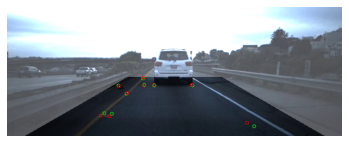

In [7]:
plt.axis('off')
plt.imshow(img_vis)

In [8]:
X_train = get_preds(train_points, train_df)
X_val = get_preds(val_points, val_df)
X_test = get_preds(test_points, test_df)

X_train = np.array(X_train).reshape(-1, 1)
X_val = np.array(X_val).reshape(-1, 1)
X_test = np.array(X_test).reshape(-1, 1)

y_train = train_df['speed']
y_val = val_df['speed']

In [9]:
lin_reg = LinearRegression(fit_intercept=False)
lin_reg = lin_reg.fit(X_train, y_train) 

y_train_preds = lin_reg.predict(X_train)
y_train_preds = movingAverage(y_train_preds, window)
# estimate training error
mse = mean_squared_error(y_train_preds, y_train)
print("MSE for train", mse)

y_val_preds = lin_reg.predict(X_val)
y_val_preds = movingAverage(y_val_preds, window)
# estimate validation error
mse = mean_squared_error(y_val_preds, y_val)
print("MSE for val", mse)

y_test_preds = lin_reg.predict(X_test)
y_test_preds = movingAverage(y_test_preds, window)

MSE for train 9.116709721256504
MSE for val 3.796437540015803


In [10]:
# Testing multiple models
classifiers = []
classifiers.append(LinearRegression(fit_intercept=False))
classifiers.append(Ridge(fit_intercept=False, random_state=rs))
classifiers.append(Lasso(fit_intercept=False, random_state=rs))
classifiers.append(HuberRegressor(fit_intercept=False))
classifiers.append(BayesianRidge(fit_intercept=False))
classifiers.append(ElasticNet(random_state=rs))
classifiers.append(LassoLars())
classifiers.append(MLPRegressor(random_state=rs))
classifiers.append(RandomForestRegressor(random_state=rs))
classifiers.append(GradientBoostingRegressor(random_state=rs))

train_mses = []
val_mses = []
for classifier in classifiers:
    classifier = classifier.fit(X_train, y_train)
    
    y_preds = classifier.predict(X_train)
    y_preds = movingAverage(y_preds, window)
    train_mses += [mean_squared_error(y_preds, y_train)]
    
    y_preds = classifier.predict(X_val)
    y_preds = movingAverage(y_preds, window)
    val_mses += [mean_squared_error(y_preds, y_val)]

cv_res = pd.DataFrame({"train_mse":train_mses,"val_mse": val_mses,\
                       "algorithm":['LinearRegression', 'Ridge', 'Lasso', \
                                    'Huber', 'BayesianRidge', 'ElasticNet',\
                                    'LassoLars','MLPRegressor',\
                                    'RandomForestRegressor', \
                                    'GradientBoostingRegressor'
                                   ]})

/home/jared/miniconda3/envs/speed_detection/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


/home/jared/miniconda3/envs/speed_detection/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jared/miniconda3/envs/speed_detection/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


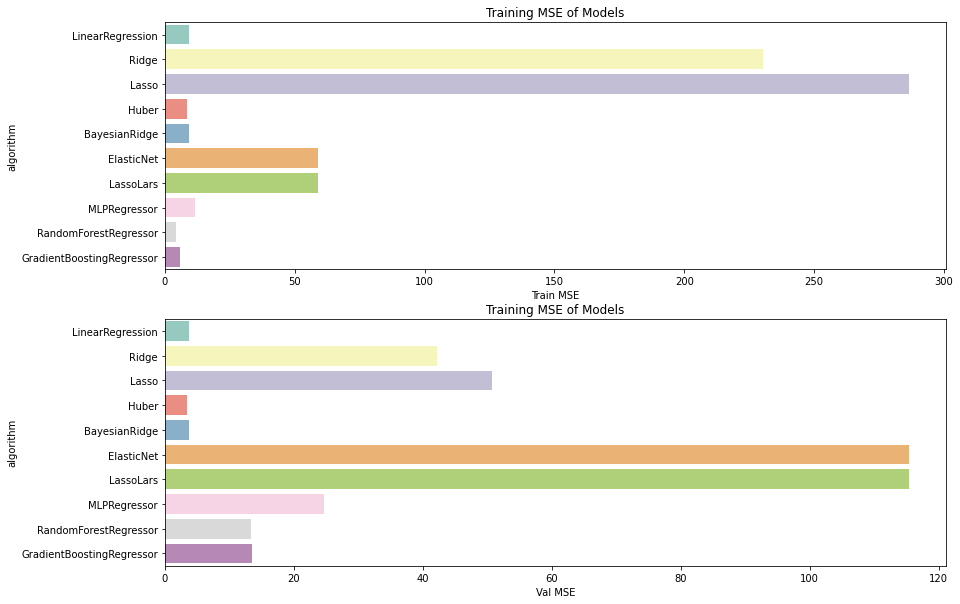

In [11]:
fig, ax = plt.subplots(2,1, figsize=(14,10))
g = sns.barplot("train_mse","algorithm",data = cv_res, palette="Set3",
                orient = "h", ax=ax[0])
g.set_xlabel("Train MSE")
g.set_title("Training MSE of Models")

g = sns.barplot("val_mse","algorithm",data = cv_res, palette="Set3",
                orient = "h", ax=ax[1])
g.set_xlabel("Val MSE")
g.set_title("Training MSE of Models")

fig.show()

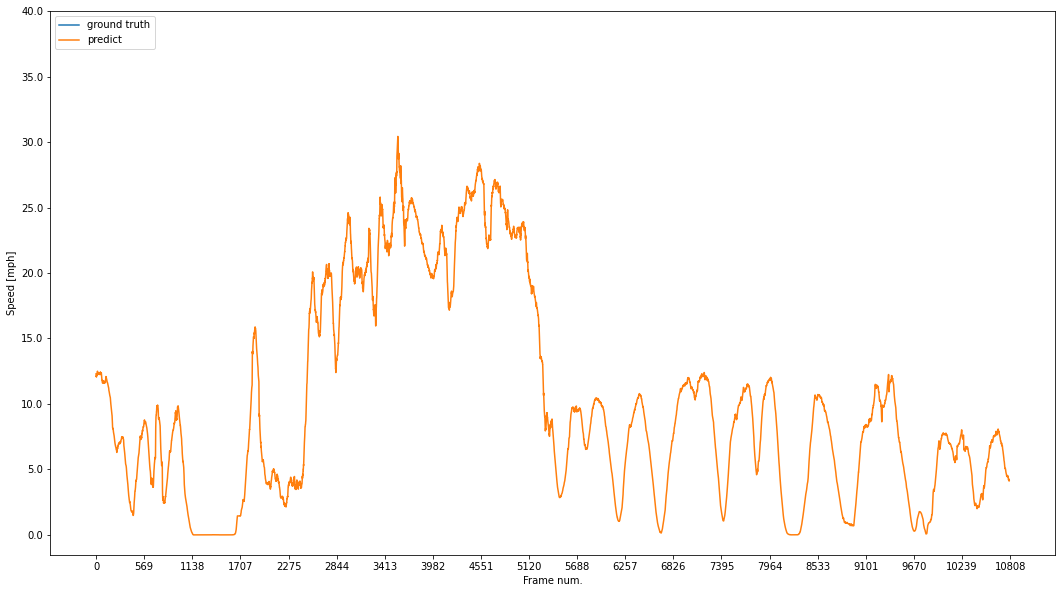

In [18]:
plot(y_test_preds, [])

In [33]:
path = str(Path('../data/test/test.txt').resolve())
y_test_preds = np.array(y_test_preds)
np.savetxt(path, y_test_preds, fmt='%1.6f')